# Train autoGAN Model

#### _The script takes in real images as Numpy arrays and trains the autoGAN model_

In [0]:
#import modules
import math
import itertools
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

from PIL import Image
import matplotlib.pyplot as plt
import torchvision.utils as utils
from torch.utils.data import DataLoader

from torch.autograd import Variable
import torch.nn.functional as F

cuda = True if torch.cuda.is_available() else False

torch.manual_seed(2)
np.random.seed(2)

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Get Data and Fix Channel Order

In [0]:
train_data=np.load("/content/gdrive/My Drive/CelebA/image_array_20000.npy")
val_data=np.load("/content/gdrive/My Drive/CelebA/image_fake_array_10000.npy")

In [0]:
if train_data.shape[1:]==(64, 64, 3):
  train_array = np.transpose(train_data, (0, 1, 3, 2))
  train_array = np.transpose(train_array, (0, 2, 1, 3))
else:
  train_array=train_data

if val_data.shape[1:]==(64, 64, 3):
  val_array = np.transpose(val_data, (0, 1, 3, 2))
  val_array = np.transpose(val_array, (0, 2, 1, 3))
else:
  val_array=val_data

# Create Dataset and Dataloader

In [0]:
class MyDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = torch.LongTensor(targets)
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]

        if self.transform:
            x = Image.fromarray(self.data[index].astype(np.uint8).transpose(1,2,0))
            x = self.transform(x)

        return x, y

    def __len__(self):
        return len(self.data)

#Normalisation of Image
transform_norm = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.25, 0.25, 0.25))])

#Loading to a Dataloader; Batch size 50
dataset = MyDataset(train_array, np.zeros((train_array.shape[0],)), transform=transform_norm)
dataloader = DataLoader(dataset, 50, shuffle=True)

dataset_val = MyDataset(val_array, np.zeros((val_array.shape[0],)), transform=transform_norm)
dataloader_val = DataLoader(dataset_val, 1, shuffle=True)

# Define Encoder, Decoder and Discriminator Models

In [0]:
import random
class ReplayBuffer:
    def __init__(self, max_size=50):
        assert max_size > 0, "Empty buffer or trying to create a black hole. Be careful."
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0, 1) > 0.5:
                    i = random.randint(0, self.max_size - 1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return Variable(torch.cat(to_return))

In [0]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
        )

    def forward(self, x):
        return x + self.block(x)


class GeneratorResNet(nn.Module):
    def __init__(self, input_shape, num_residual_blocks):
        super(GeneratorResNet, self).__init__()

        global in_features
        global out_features
        channels = input_shape[0]
        out_features = 64
        # Initial convolution block

        model = [
            nn.ReflectionPad2d(channels),
            nn.Conv2d(channels, out_features, 7),
            nn.InstanceNorm2d(out_features),
            nn.ReLU(inplace=True),
        ]
        in_features = out_features

        # Downsampling
        for _ in range(2):
            out_features *= 2
            model += [
                nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features

        # Residual blocks
        for _ in range(num_residual_blocks):
            model += [ResidualBlock(out_features)]
        
        self.model = nn.Sequential(*model)
    def forward(self, x):
        return self.model(x)


class DecoderResNet(nn.Module):
    def __init__(self, input_shape, num_residual_blocks):
        super(DecoderResNet, self).__init__()

        global in_features
        global out_features
        channels = input_shape[0]
        model=[]
        # Upsampling
        for _ in range(2):
            out_features //= 2
            model += [
                nn.Upsample(scale_factor=2),
                nn.Conv2d(in_features, out_features, 3, stride=1, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features

        # Output layer
        model += [nn.ReflectionPad2d(channels), nn.Conv2d(out_features, channels, 7), nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)


##############################
#        Discriminator
##############################


class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()

        channels, height, width = input_shape

        # Calculate output shape of image discriminator (PatchGAN)
        self.output_shape = (1, height // 2 ** 4, width // 2 ** 4)

        def discriminator_block(in_filters, out_filters, normalize=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(channels, 64, normalize=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1)
        )

    def forward(self, img):
        return self.model(img)

# Define Models, Optimizers and Loss Functions

In [0]:
#Run Model (Needs all definiations)

input_shape = (3, 64, 64)
global out_features
global in_features
G_AB = GeneratorResNet(input_shape, 4)
G_AB.cuda()
G_AB_d = DecoderResNet(input_shape, 4)
G_AB_d.cuda()
D_A = Discriminator(input_shape)
D_A.cuda()


fake_A_buffer = ReplayBuffer()

criterion_GAN = torch.nn.MSELoss()
criterion_GAN.cuda()
criterion_identity = torch.nn.L1Loss()
criterion_identity.cuda()


optimizer_G = torch.optim.Adam(itertools.chain(G_AB.parameters(), G_AB_d.parameters()), lr=0.0002, betas=[0.8, 0.9]) #Tune this part
optimizer_D_A = torch.optim.Adam(D_A.parameters(), lr=0.0002, betas=[0.8, 0.9]) #Tune this part

# Train the network

In [0]:
 def sample_images(batches_done):
  """Saves a generated sample from the test set"""
  imgs, _ = next(iter(dataloader_val))
  G_AB.eval()
  G_AB_d.eval()
  real_A = Variable(imgs.type(Tensor))

  fake_A = G_AB_d(G_AB(real_A))

  utils.save_image(fake_A, "/content/imgs/images%s.png" % batches_done, normalize=False)
  utils.save_image(real_A, "/content/imgs/images1%s.png" % batches_done, normalize=False)


# ----------
#  Training
# ----------
sample_interval=1000
sample=False
save=False
t_loss_list = []
id_loss_list = []
d_loss_list = []

for epoch in range(25):

    t_loss=0
    id_loss=0
    d_loss=0
    for i, (imgs, _) in enumerate(dataloader):

        # Set model input
        real_A = Variable(imgs.type(Tensor))

        # Adversarial ground truths
        valid = Variable(Tensor(np.ones((real_A.size(0), *D_A.output_shape))), requires_grad=False)
        fake = Variable(Tensor(np.zeros((real_A.size(0), *D_A.output_shape))), requires_grad=False)

        # ------------------
        #  Train Generators
        # ------------------

        G_AB.train()
        G_AB_d.train()

        optimizer_G.zero_grad()

        # Identity loss
        a=G_AB(real_A)
        loss_id_A = criterion_identity(G_AB_d(a), real_A)

        loss_identity = (loss_id_A)

        # GAN loss
        fake_A = G_AB_d(G_AB(real_A))
        loss_GAN_AB = criterion_GAN(D_A(fake_A), valid)
     
        loss_GAN = (loss_GAN_AB)

        # Total loss
        loss_G = (loss_GAN + 0.8 * loss_identity)/1.8    #Tune this part

        loss_G.backward()
        optimizer_G.step()

        # -----------------------
        #  Train Discriminator
        # -----------------------

        optimizer_D_A.zero_grad()

        # Real loss
        loss_real = criterion_GAN(D_A(real_A), valid)
        # Fake loss (on batch of previously generated samples)
        fake_A_ = fake_A_buffer.push_and_pop(fake_A)
        loss_fake = criterion_GAN(D_A(fake_A_.detach()), fake)
        # Total loss
        loss_D_A = (loss_real + loss_fake) / 2

        loss_D_A.backward()
        optimizer_D_A.step()



        batches_done = epoch * len(dataloader) + i

        # If at sample interval save image
        if sample:
          if batches_done % sample_interval == 0:
            sample_images(batches_done)
        
        t_loss=loss_G.item()
        id_loss=loss_id_A.item()
        d_loss=loss_D_A.item()

        if save:
          torch.save({'epoch': epoch,
                  'model_state_dict': [G_AB.state_dict(), G_AB_d.state_dict(), D_A.state_dict()],
                  'optimizer_state_dict': [optimizer_G.state_dict, optimizer_D_A.state_dict()],
                  'loss': [loss_G,loss_D_A]}, "/content/gdrive/My Drive/CelebA/DL_GAN_train_"+str(epoch))
    

    print(epoch, "Total loss:%f, ID loss:%f,  Discriminator loss:%f" %(t_loss, id_loss, d_loss))
    t_loss_list.append(t_loss)
    id_loss_list.append(id_loss)
    d_loss_list.append(d_loss)


0 Total loss:0.891335, ID loss:0.748090,  Discriminator loss:0.024538
1 Total loss:1.038211, ID loss:1.087119,  Discriminator loss:0.010393
2 Total loss:0.800878, ID loss:0.566271,  Discriminator loss:0.001506
3 Total loss:0.769536, ID loss:0.515690,  Discriminator loss:0.001155
4 Total loss:0.791396, ID loss:0.525894,  Discriminator loss:0.005209
5 Total loss:0.736315, ID loss:0.451950,  Discriminator loss:0.003128
6 Total loss:0.747026, ID loss:0.455156,  Discriminator loss:0.000818
7 Total loss:0.766549, ID loss:0.405997,  Discriminator loss:0.001628
8 Total loss:0.712547, ID loss:0.421280,  Discriminator loss:0.001410
9 Total loss:0.712304, ID loss:0.414582,  Discriminator loss:0.000983
10 Total loss:0.730891, ID loss:0.374139,  Discriminator loss:0.000387
11 Total loss:0.702483, ID loss:0.385116,  Discriminator loss:0.006788
12 Total loss:0.758576, ID loss:0.397790,  Discriminator loss:0.000741
13 Total loss:0.723479, ID loss:0.426775,  Discriminator loss:0.008793
14 Total loss:0.

# Plot Model Losses

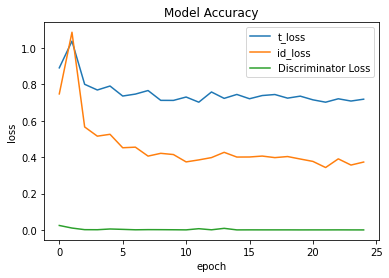

In [0]:
import matplotlib.pyplot as plt

plt.plot(t_loss_list)
plt.plot(id_loss_list)
plt.plot(d_loss_list)
plt.title('Model Accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['t_loss', 'id_loss', 'Discriminator Loss'])
plt.show()

# Save the model

In [0]:
torch.save({'epoch': epoch,
                  'model_state_dict': [G_AB.state_dict(), G_AB_d.state_dict(), D_A.state_dict()],
                  'optimizer_state_dict': [optimizer_G.state_dict, optimizer_D_A.state_dict()],
                  'loss': [loss_G,loss_D_A]}, "/content/gdrive/My Drive/CelebA/DL_GAN_train_master_4LAYER")